# This jupyter notebook is for UNSW COMP9517
# Assignment 01 Cell Detection

## Task 1 Otsu Algorithm and HSV threshold

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
#######################################################################################################################
# This function is to implement Otsu algorithm
# STEP 1 Compute histogram and probabilities of each intensity pixel
# STEP 2 Setup initial w0 and u0
# STEP 3 Step through all possible thresholds t=1,...maximum intensity
#           a. Update wi and ui b. Compute 𝜎
# STEP 4 Desired threshold corresponds to the maximum 𝜎
#######################################################################################################################
def Otsu(image_name):
    # Read the image from the dir
    image = cv2.imread(image_name,0)
    # STEP 1: calculating the histogram 
    frequency_vector = [0 for i in range(0,256)]
    frequency_vector = np.array(frequency_vector)
    # test the type of the list
    # print(type(frequency_vector))
    row = image.shape[0]
    col = image.shape[1]
    for r in range(row):
        for c in range(col):
            point_value = image[r,c]
            frequency_vector[point_value] += 1
    
    total_pixels = row * col
    # The value of the pixel is 0 ----> get the value
    # pixel_value which is 0 is the forground
    # pixel_value which is not 0 is the background
    foreground_pixel = frequency_vector[0]
    background_pixel = total_pixels - foreground_pixel

    # initialize the size
    foreground_pixel_total_value = 0 
    background_pixel_total_value = 0

    for index in range(0,256,1):
        # This step is to do the Statistics
        # Getting the background total pixel value
        # Source: https://en.wikipedia.org/wiki/Histogram
        # adding the value which is value i * frequency i is just like a kind of weighted method
        background_pixel_total_value = background_pixel_total_value + index * frequency_vector[index]

    # w0 is the proportion of foreground pixels in the entire image
    w0 = foreground_pixel/total_pixels
    # w1 is the proportion of background pixels in the entire image
    w1 = background_pixel/total_pixels

    # u0 is the mean of the foreground pixel value
    # This means using the total value of foreground pixel to devide the total number of the foreground pixels
    if foreground_pixel <= 0:
        u0 = 0
    else:
        # maybe we should add float here due to the division
        u0 = float(foreground_pixel_total_value) / foreground_pixel

    # u1 is the mean of the background pixel value
    # This means using the total value of background pixel to devide the total number of the background pixels
    if background_pixel <= 0:
        u1 = 0
    else:
        # maybe we should add float here due to the division
        u1 = float(background_pixel_total_value) / background_pixel

    # sigma^2_b(t)=omega_1(t) * omega_2(t) * [ mu_1(t) - mu_2(t) ]^2
    # Source: https://en.wikipedia.org/wiki/Otsu%27s_method#cite_note-Otsu-2
    # This intra_class_variance list is to store the value and doing the camparing
    intra_class_variance = list()
    intra_class_variance.append(w0*w1*pow((u0-u1),2))

    # After getting the intra_class variable
    # Going through the threshold by using for and updating u0 u1 and intra_class_variance
    # This is similar with cv2.threshold
    # defining the threshold from 1 - 255 using the for loop one by one
    # test which threshold is the best
    for threshold in range(1,255,1):
        # For example: if the foreground pixel +1 the background pixel -1
        foreground_pixel = foreground_pixel + frequency_vector[threshold] 
        background_pixel = background_pixel - frequency_vector[threshold]
        # For example: if the foreground_pixel_total_value + the background_pixel_total_value -
        foreground_pixel_total_value = foreground_pixel_total_value + threshold * frequency_vector[threshold]
        background_pixel_total_value = background_pixel_total_value - threshold * frequency_vector[threshold]
        # Updating w0 w1
        w0 = foreground_pixel / total_pixels
        w1 = background_pixel / total_pixels

        # After we get the new point updating the u0 
        if foreground_pixel <= 0:
            u0 = 0
        else:
            # maybe we should add float here due to the division
            u0 = float(foreground_pixel_total_value) / foreground_pixel
        
        # After we get the new point updating the u1
        if background_pixel <= 0:
            u1 = 0
        else:
            # maybe we should add float here due to the division
            u1 = float(background_pixel_total_value) / background_pixel
        # updating the intra_class_variance by appending the result provided by threshold
        # the format of intra_class_variance is intra_class_variance[threshold] = intra class variance
        # This means index is threshold and value is variance
        intra_class_variance.append(w0*w1*pow((u0-u1),2))

    # Get the max value of intra class variance
    max_variance = max(intra_class_variance)
    # Get the max threshold
    threshold = intra_class_variance.index(max_variance)
    # print the threshold and max intra class variance
    # print(max_variance, threshold)


    # Threshold the input picture
    for r in range(row):
        for c in range(col):
            if image[r,c] < threshold:
                # less than threshold change to 255
                image[r,c] = 255
            else:
                # greater than threshold change to 0
                image[r,c] = 0

    return image,threshold,max_variance

Threshold: 201   Max_variance: 1920.1336333126987


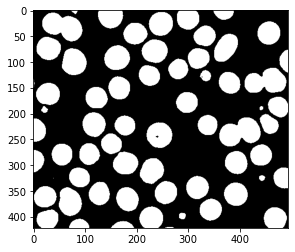

In [3]:
#######################################################################################################################
# 
# Printing the Otsu image 1
#
#######################################################################################################################
img1, threshold1, max_variance1 = Otsu("c1.jpg")
print("Threshold:",threshold1, "  Max_variance:",max_variance1)
plt.imshow(img1,"gray")

Threshold: 201   Max_variance: 1864.3635718461346


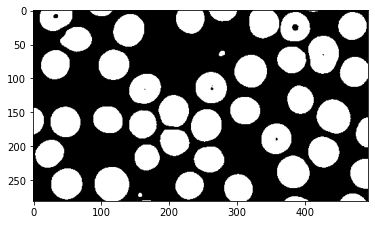

In [4]:
#######################################################################################################################
# 
# Printing the Otsu image 2
#
#######################################################################################################################
img2, threshold2, max_variance2 = Otsu("c2.jpg")
print("Threshold:",threshold2, "  Max_variance:",max_variance2)
plt.imshow(img2,"gray")

Threshold: 201   Max_variance: 1869.7091961362376


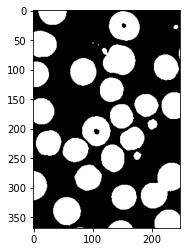

In [5]:
#######################################################################################################################
# 
# Printing the Otsu image 3
#
#######################################################################################################################
img3, threshold3, max_variance3 = Otsu("c3.jpg")
print("Threshold:",threshold3, "  Max_variance:",max_variance3)
plt.imshow(img3,"gray")

Threshold: 201   Max_variance: 1868.6850123988147


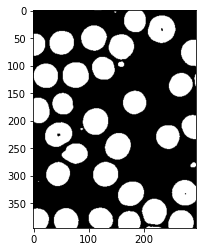

In [6]:
#######################################################################################################################
# 
# Printing the Otsu image 4
# 
#######################################################################################################################
img4, threshold4, max_variance4 = Otsu("c4.jpg")
print("Threshold:",threshold4, "  Max_variance:",max_variance4)
plt.imshow(img4,"gray")

In [7]:
#######################################################################################################################
# 
# HSV thresholding
#
#######################################################################################################################
def HSV_threshold(image_name):
    image = cv2.imread(image_name)
    # This select BGR2HSV
    # The following operation will be done in HSV space
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    # HSV with 3 channel which is a m * n * 3 matrix(you can check the following source in English)
    # Source: https://ww2.mathworks.cn/help/matlab/ref/hsv2rgb.html
    hsv_1st_dimension = hsv[:,:,0]
    # This is to check the hsv format which is (422, 494, 3)
    # We need to cut the (422,494)
    # print(hsv.shape)
    # print(hsv.shape[:2])
    new_hsv_shape = hsv.shape[:2]
    # Do the reshape for HSV
    new_hsv = hsv_1st_dimension.reshape(new_hsv_shape)
    # print(hsv_1st_dimension)

    # A error do not forget the shape
    height, width = new_hsv.shape
     
    # This is for the HSV thresholding result
    gray_img = np.zeros_like(new_hsv)

    # Basic is purple which is h[125,155] s[43,255] v[46,255]
    # Current the best without small cell h[125,165] s[43,255] v[46,255]
    # can find small cell h[125,170] s[43,255] v[46,255]
    # current the best with small cell h[125, 170] s[42, 255] v[46, 255]
    hue_threshold = (125, 170)
    saturation_threshold = (42, 255)
    value_threshold = (46, 255)

    # Doing the threshold
    # This HSV threshold is based on the dimension in the hsv matrix
    # Filter hue layer then saturation layer then value layer
    for h in range(height):
        for w in range(width):
            # check the whether the hue is in the range of threshold
            if hsv[h,w,0] in range(*hue_threshold):
                # check the whether the saturation is in the range of threshold
                if hsv[h,w,1] in range(*saturation_threshold):
                    # check the whether the value is in the range of threshold
                    if hsv[h,w,2] in range(*value_threshold):
                        gray_img[h,w] = 255
            else:
                gray_img[h,w] = 0
    return gray_img,hue_threshold,saturation_threshold,value_threshold

Hue threshold: (125, 170)   Saturation threshold: (42, 255)   Value threshold: (46, 255)


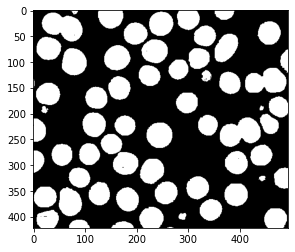

In [8]:
#######################################################################################################################
# 
# Printing the HSV thresholding image 5
# 
#######################################################################################################################
img5, h_threshold, s_threshold, v_threshold = HSV_threshold("c1.jpg")
print("Hue threshold:", h_threshold ,"  Saturation threshold:", s_threshold ,"  Value threshold:",v_threshold)
plt.imshow(img5,"gray")

Hue threshold: (125, 170)   Saturation threshold: (42, 255)   Value threshold: (46, 255)


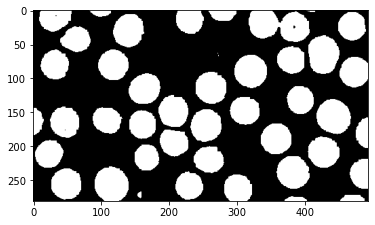

In [9]:
#######################################################################################################################
# 
# Printing the HSV thresholding image 6
#
#######################################################################################################################
img6, h_threshold, s_threshold, v_threshold = HSV_threshold("c2.jpg")
print("Hue threshold:", h_threshold ,"  Saturation threshold:", s_threshold ,"  Value threshold:",v_threshold)
plt.imshow(img6,"gray")

Hue threshold: (125, 170)   Saturation threshold: (42, 255)   Value threshold: (46, 255)


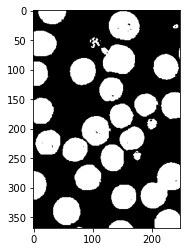

In [10]:
#######################################################################################################################
#
#  Printing the HSV thresholding image 7
#
#######################################################################################################################
img7, h_threshold, s_threshold, v_threshold = HSV_threshold("c3.jpg")
print("Hue threshold:", h_threshold ,"  Saturation threshold:", s_threshold ,"  Value threshold:",v_threshold)
plt.imshow(img7,"gray")

Hue threshold: (125, 170)   Saturation threshold: (42, 255)   Value threshold: (46, 255)


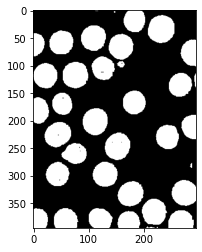

In [11]:
#######################################################################################################################
#
#  Printing the HSV thresholding image 8
# 
#######################################################################################################################
img8, h_threshold, s_threshold, v_threshold = HSV_threshold("c4.jpg")
print("Hue threshold:", h_threshold ,"  Saturation threshold:", s_threshold ,"  Value threshold:",v_threshold)
plt.imshow(img8,"gray")

In [79]:
#######################################################################################################################
#
# This function is to print all these 4 picture into a same graph
#
#######################################################################################################################
def show_img_Task1(image_name):
    img_input = cv2.imread(image_name)
    img_Otsu, threshold, max_variance = Otsu(image_name)
    img_HSV, h_threshold, s_threshold, v_threshold = HSV_threshold(image_name)

    # plt.figure(facecolor='white',edgecolor='white')

    plt.figure(figsize=(21,7))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title('input image',fontsize=20)
    plt.imshow(img_input)

    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.title(f'Otsu\'s Method(threshold:{threshold} variance:{round(max_variance)})',fontsize=18)
    plt.imshow(img_Otsu,'gray')

    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.title(f'HSV Method',fontsize=20)
    plt.imshow(img_HSV,'gray')

    name = image_name.split(".",1)[0]
    plt.savefig(f"{name}_output",transparent = True)

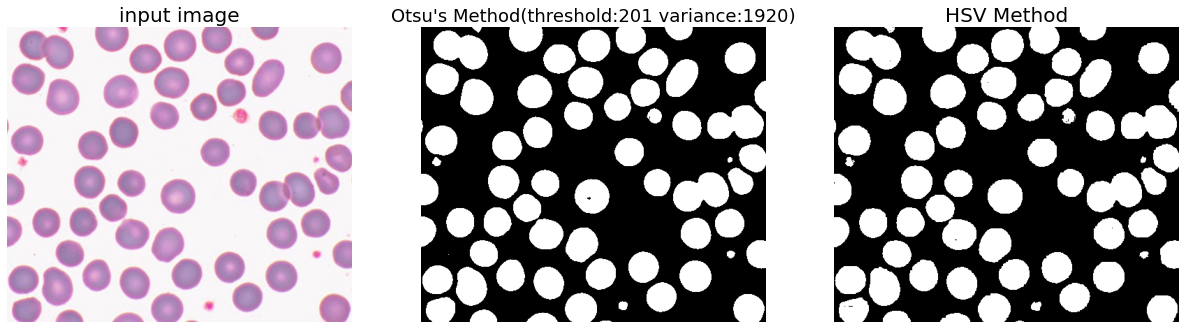

In [80]:
show_img_Task1('c1.jpg')

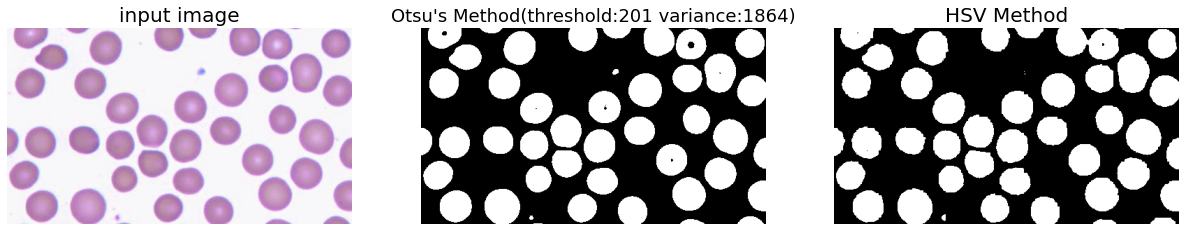

In [81]:
show_img_Task1('c2.jpg')

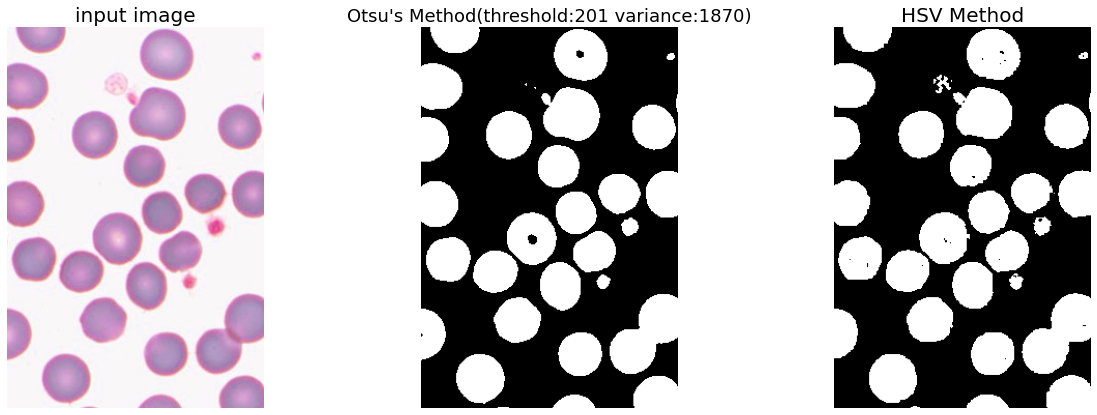

In [82]:
show_img_Task1('c3.jpg')

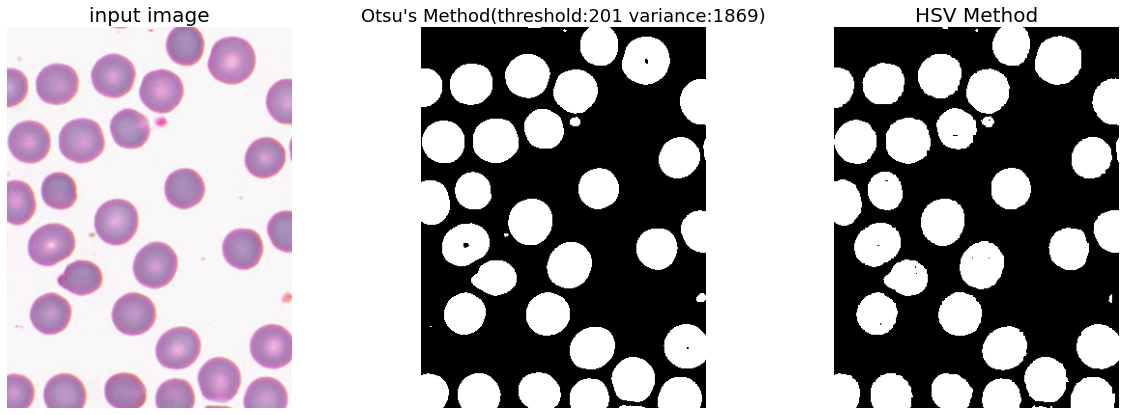

In [83]:
show_img_Task1('c4.jpg')

## Task 2 Counting the number of cells

In [17]:
# Task 2 start 
# STEP 1 median filter ------> remove noise
# STEP 2 TWO-pass Method ------> Object Counting

In [25]:
#######################################################################################################################
# Median filter select the median value
# Source: https://en.wikipedia.org/wiki/Median_filter
# How to implement the median filter? Some ideas from the following source.
# Source: https://codereview.stackexchange.com/questions/191974/median-filter-implementation-in-python
#######################################################################################################################
def median_filter(image):
    row = image.shape[0]
    col = image.shape[1]
    
    # In this median filter the window is 3 * 3
    # Therefore we can use the direction instead the window to select the value
    # The idea is from the following source
    # Source: https://codereview.stackexchange.com/questions/191974/median-filter-implementation-in-python
    
    # example
    #   (-1,-1)     (-1,0)      (-1,1)
    #   (0,-1)      (0,0)       (0,1)
    #   (1,-1)      (1,0)       (1,1)
    
    direction_vector = list([-1,0,1])
    
    # Notice the data type should be int8 which is [0-255]
    filter_result = np.zeros_like(image,dtype=np.uint8)

    # store the median value
    # temp_values

    # go through the picture
    for r in range(row):
        for c in range(col):
            temp_values = list()
            # go throught the picture by using the filter window
            for r_median in direction_vector:

                for c_median in direction_vector:
                    # Getting the new position
                    new_direction = [r+r_median,c+c_median]
                    # get the new row number and check whether it is in the range(row)
                    if new_direction[0] in range(row):
                        # Then get the new col number and check whether it is in the range(col)
                        if new_direction[1] in range(col):
                            # Select the 3*3 data from the image
                            # This 3*3 is the size of the window which described by the direction
                            temp_values.append(image[new_direction[0] , new_direction[1]])
            
            # put the result in the current position in filter result
            # How to select median by using numpy
            # Source: https://numpy.org/doc/stable/reference/generated/numpy.median.html
            filter_result[r, c] = np.median(temp_values)

    return filter_result

In [26]:
#######################################################################################################################
# Two pass method 
# Source: https://jacklj.github.io/ccl/
#######################################################################################################################
# How to do the label?
#    0
# 0  ？ x  The top and left here is 0, therefore we need to put a new value in the center. 
#    x     For example, if the previous is 2, then we should put 3 in the center
#######################################################################################################################
#    1
# 3  ？ x  select the top and left value, the center here is 1 due to selecting the min value and put it in the center
#    x
#######################################################################################################################
# How to understand the merge of dictionary in first pass method?
# In this part designing the key as the label, the value of key is a set
# The value set will store all these labels which are connected with it
# Therefore, in the second pass we can save more time by change the label to the min in the set
#######################################################################################################################

def Two_Pass_Method(image):
    # get the row and col from the shape
    row = image.shape[0]
    col = image.shape[1]
    
    # create the same size zero matrix used to store the label
    # This is an error this place is uint32 not uint8
    image_label = np.zeros_like(image,dtype=np.uint32)

    # This dictionary is used to store the set of object
    # Can also choose tree structure to solve it
    equivalent_sets = dict()

    # This min_label is to store the data for the first pass
    min_label = dict()

    # The first pass is to set the label for foreground pixel in the image

    # initial the label
    initial_label = 1
    # Go through the image and lable each pixel
    for r in range(row):
        for c in range(col):
            
            # Omit the background pixel
            if image[r,c] <= 0:
                 pass
            # this is the foregound pixel
            first_pass_value = list()
            if image[r,c] > 0:
                # select the top left bottom right pixel
                # This is similar with the median_filter in this assignment
                
                # Top (i-1,j) Left (i,j-1) bottom (i+1,j) right(i,j+1)

                # If the current label is grater than 0 add to first_pass_value list to store
                # Top side
                if r - 1 in range(row):
                    if image_label[r - 1,c] > 0:
                        first_pass_value.append(image_label[r - 1,c])

                # Left side
                if c - 1 in range(col):
                    if image_label[r,c - 1] > 0:
                        first_pass_value.append(image_label[r,c - 1])

                # Bottom side
                if r + 1 in range(row):
                    if image_label[r + 1,c] > 0:
                        first_pass_value.append(image_label[r + 1,c])
                # Right side
                if c + 1 in range(col):
                    if image_label[r,c + 1] > 0:
                        first_pass_value.append(image_label[r,c + 1])
                
                # This mean first_pass_value has found label of foreground
                # Then moving the lable to the next position
                if first_pass_value == []:
                    # If not found, set the center r,c a new label
                    image_label[r , c] = initial_label
                    # create a new set in the dictionary to store the pixel 
                    equivalent_sets[initial_label] = set()
                    equivalent_sets[initial_label].add(initial_label)
                    # After labeling, the label add 1
                    initial_label = initial_label + 1

                # Not found the foreground
                if first_pass_value != []:
                    # The center should Select the min value
                    image_label[r,c] = min(first_pass_value)
                    # get the current pixel min label value 
                    min_value = image_label[r,c]
                    for item in first_pass_value:
                        # check whether these 2 point to same position
                        if equivalent_sets[item] is equivalent_sets[min_value]:
                            continue
                        else:
                            pass
                        # update and merge
                        equivalent_sets[min_value].update(equivalent_sets[item])
                        # merge the dictionary
                        equivalent_sets[item] = equivalent_sets[min_value]
                # This mean first_pass_value has not found label of frontground


    # Collecting the min label
    # This min_label will improve the efficiency that claculating the min label
    # Otherwise, you need to calculate the value everytime.
    for key in equivalent_sets:
        min_value = min(equivalent_sets[key])
        min_label[key] = min_value
    
    # Second pass: collecting the label from the first pass
    for r in range(row):
        for c in range(col):
            # background pixel
            # This is the background
            if image_label[r, c] <= 0:
                pass
            # check the foreground number
            if image_label[r, c] > 0:
                image_label[r, c] = min_label[image_label[r, c]]
    return image_label

In [27]:
#######################################################################################################################
# Counting cell number
# 
# Counting the image_label is the final result --------> compare length(label) with min and overlap
# less than min -------> noise
# greater than overpla ---------> 2 cells --------> add another one
#######################################################################################################################
def counting_cell_num(image_label,min_area,overlap_area):
    # get the number of row and col
    row = image_label.shape[0]
    col = image_label.shape[1]
    # cell number 
    cell_num = 0 
    label_statics = set()
    for r in range(row):
        for c in range(col):
            # This part is to check the non zero label
            # zero lable is the background
            # same are the previous part of code
            if image_label[r,c] <=0:
                pass
            # non-zero lable is the foreground
            if image_label[r,c] > 0:
                label_statics.add(image_label[r,c])
    

    for item in label_statics:
        # This area is to check the length of the vector
        # This length is also the area of different labels
        area = len(image_label[image_label == item])
        if area >= min_area:
            # cells 
            cell_num += 1
        else:
            # less than noise
            cell_num += 0
        if area >= overlap_area:
            # cells 
            cell_num += 1
        else:
            # noise
            cell_num += 0

    return cell_num


In [44]:
#######################################################################################################################
# 
# Counting the number of the image c1(Otsu)
# 
#######################################################################################################################
image1, threshold1, max_variance1 = Otsu("c1.jpg")
image1_filter = median_filter(image1)
image_labels1 = Two_Pass_Method(image1_filter) 
cells1 = counting_cell_num(image_labels1, 900, 2200)

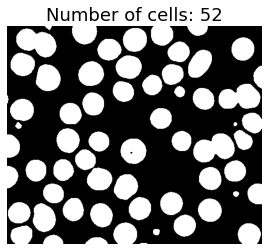

In [45]:
#######################################################################################################################
# 
# Printing the number of the image c1(Otsu)
# 
#######################################################################################################################
plt.imshow(image1_filter, cmap="gray") 
plt.title(f"Number of cells: {cells1}",fontsize=18)
plt.axis('off')
plt.show()

In [43]:
#######################################################################################################################
# 
# Counting the number of the image c2(Otsu)
# 
#######################################################################################################################
image2, threshold2, max_variance2 = Otsu("c2.jpg")
image2_filter = median_filter(image2)
image_labels2 = Two_Pass_Method(image2_filter) 
cells2 = counting_cell_num(image_labels2, 900, 2200)

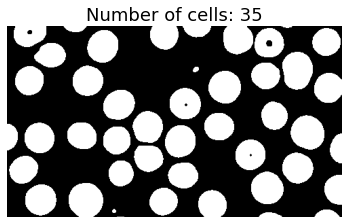

In [31]:
#######################################################################################################################
# 
# Printing the number of the image c2(Otsu)
# 
#######################################################################################################################
plt.imshow(image2_filter, cmap="gray") 
plt.title(f"Number of cells: {cells2}",fontsize=18)
plt.axis('off')
plt.show()

In [38]:
#######################################################################################################################
# 
# Counting the number of the image c3(Otsu)
# 
#######################################################################################################################
image3, threshold3, max_variance3 = Otsu("c3.jpg")
image3_filter = median_filter(image3)
image_labels3 = Two_Pass_Method(image3_filter) 
cells3 = counting_cell_num(image_labels3, 900, 2200)

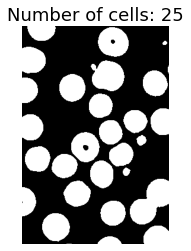

In [37]:
#######################################################################################################################
# 
# Printing the number of the image c3(Otsu)
# 
#######################################################################################################################
plt.imshow(image3_filter, cmap="gray") 
plt.title(f"Number of cells: {cells3}",fontsize=18)
plt.axis('off')
plt.show()

In [48]:
#######################################################################################################################
# 
# Counting the number of the image c4(Otsu)
# 
#######################################################################################################################
image4, threshold4, max_variance4 = Otsu("c4.jpg")
image4_filter = median_filter(image4)
img_labels4 = Two_Pass_Method(image4_filter) 
cells4 = counting_cell_num(img_labels4, 900, 2200)

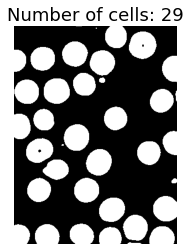

In [49]:
#######################################################################################################################
# 
# Printing the number of the image c4(Otsu)
# 
#######################################################################################################################
plt.imshow(image4_filter, cmap="gray") 
plt.title(f"Number of cells: {cells4}",fontsize=18)
plt.axis('off')
plt.show()

In [50]:
#######################################################################################################################
# 
# Counting the number of the image c1(HSV)
# 
#######################################################################################################################
image5, h_threshold, s_threshold, v_threshold = HSV_threshold("c1.jpg")
image5_filter = median_filter(image5)
img_labels5 = Two_Pass_Method(image5_filter) 
cells5 = counting_cell_num(img_labels5, 900, 2200)

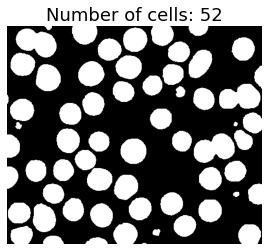

In [54]:
#######################################################################################################################
# 
# Printing the number of the image c1(HSV)
# 
#######################################################################################################################
plt.imshow(image5_filter, cmap="gray") 
plt.title(f"Number of cells: {cells5}",fontsize=18)
plt.axis('off')
plt.show()

In [55]:
#######################################################################################################################
# 
# Counting the number of the image c2(HSV)
# 
#######################################################################################################################
image6, h_threshold, s_threshold, v_threshold = HSV_threshold("c2.jpg")
image6_filter = median_filter(image6)
img_labels6 = Two_Pass_Method(image6_filter) 
cells6 = counting_cell_num(img_labels6, 900, 2200)

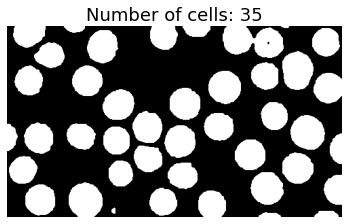

In [56]:
#######################################################################################################################
# 
# Printing the number of the image c2(HSV)
# 
#######################################################################################################################
plt.imshow(image6_filter, cmap="gray") 
plt.title(f"Number of cells: {cells6}",fontsize=18)
plt.axis('off')
plt.show()

In [59]:
#######################################################################################################################
# 
# Counting the number of the image c3(HSV)
# 
#######################################################################################################################
image7, h_threshold, s_threshold, v_threshold = HSV_threshold("c3.jpg")
image7_filter = median_filter(image7)
img_labels7 = Two_Pass_Method(image7_filter) 
cells7 = counting_cell_num(img_labels7, 900, 2200)

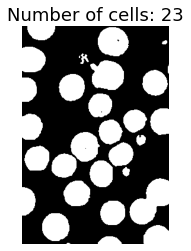

In [58]:
#######################################################################################################################
# 
# Printing the number of the image c3(HSV)
# 
#######################################################################################################################
plt.imshow(image7_filter, cmap="gray") 
plt.title(f"Number of cells: {cells7}",fontsize=18)
plt.axis('off')
plt.show()

In [57]:
#######################################################################################################################
# 
# Counting the number of the image c4(HSV)
# 
#######################################################################################################################
image8, h_threshold, s_threshold, v_threshold = HSV_threshold("c4.jpg")
image8_filter = median_filter(image8)
img_labels8 = Two_Pass_Method(image8_filter) 
cells8 = counting_cell_num(img_labels8, 900, 2200)

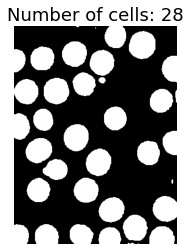

In [60]:
#######################################################################################################################
# 
# Printing the number of the image c4(HSV)
# 
#######################################################################################################################
plt.imshow(image8_filter, cmap="gray") 
plt.title(f"Number of cells: {cells8}",fontsize=18)
plt.axis('off')
plt.show()

In [69]:
def show_counting_num(original_image,img_Otsu,cell_Otsu,img_HSV,cell_HSV):
    
    name = original_image.split(".",1)[0]

    plt.figure(figsize=(20,10))

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(f'(Otsu {name}) Number of cells: {cell_Otsu})',fontsize=22)
    plt.imshow(img_Otsu,'gray')

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title(f'(HSV {name}) Number of cells: {cell_HSV})',fontsize=22)
    plt.imshow(img_Otsu,'gray')

    plt.savefig(f"{name}_number_of_cells_contrast",transparent = True)



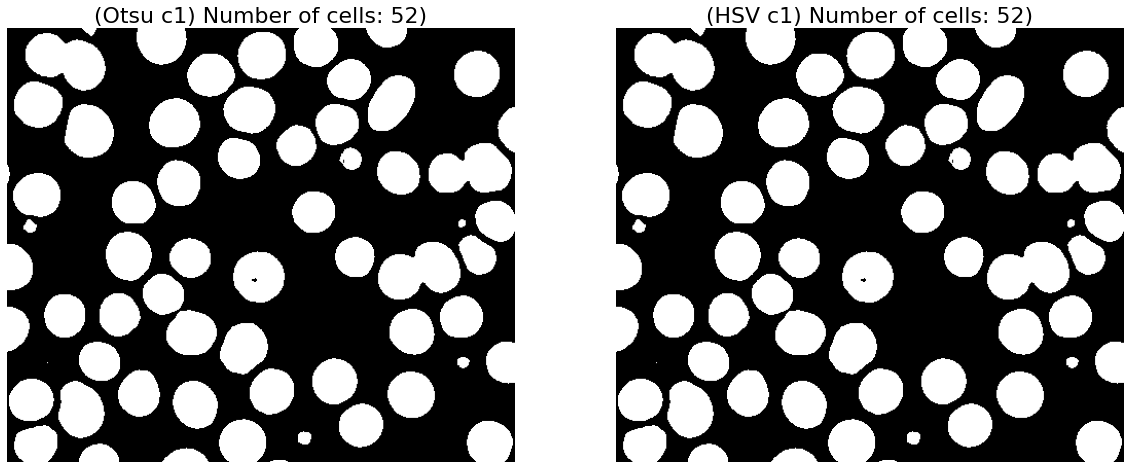

In [70]:
show_counting_num('c1.jpg',image1,cells1,image5,cells5)

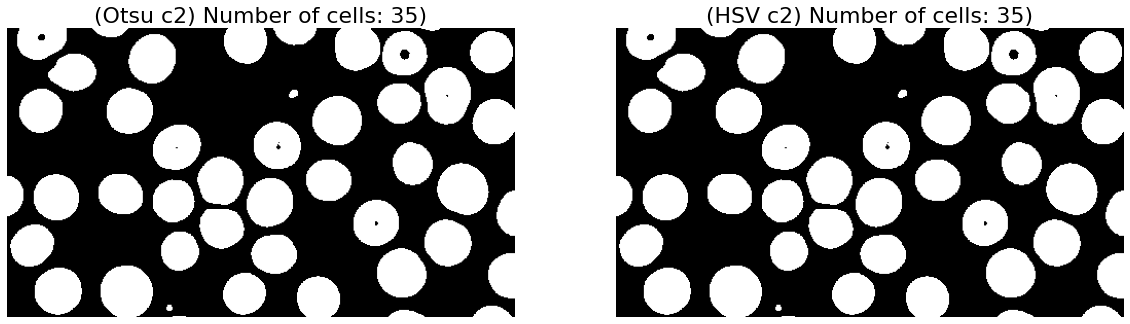

In [71]:
show_counting_num('c2.jpg',image2,cells2,image6,cells6)

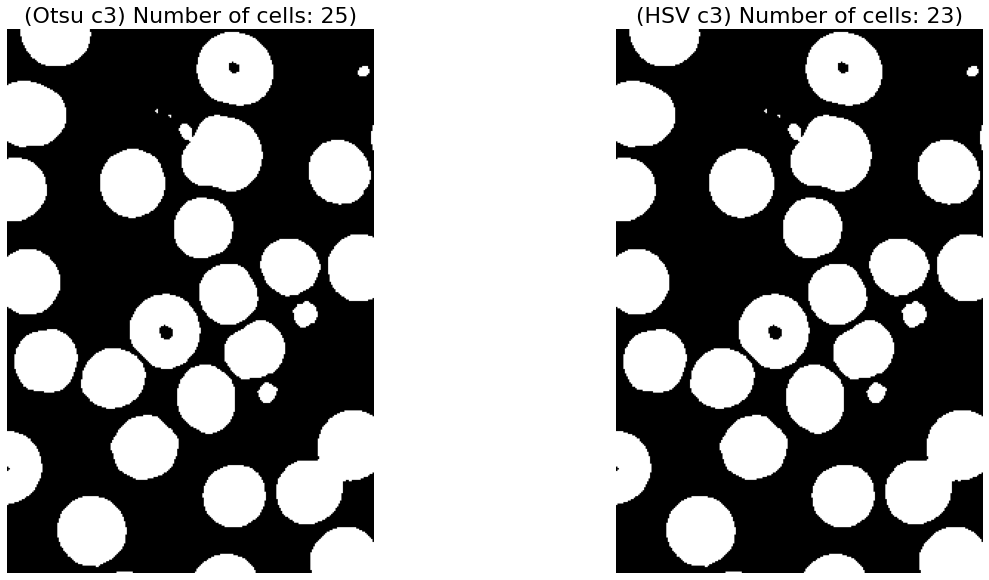

In [72]:
show_counting_num('c3.jpg',image3,cells3,image7,cells7)

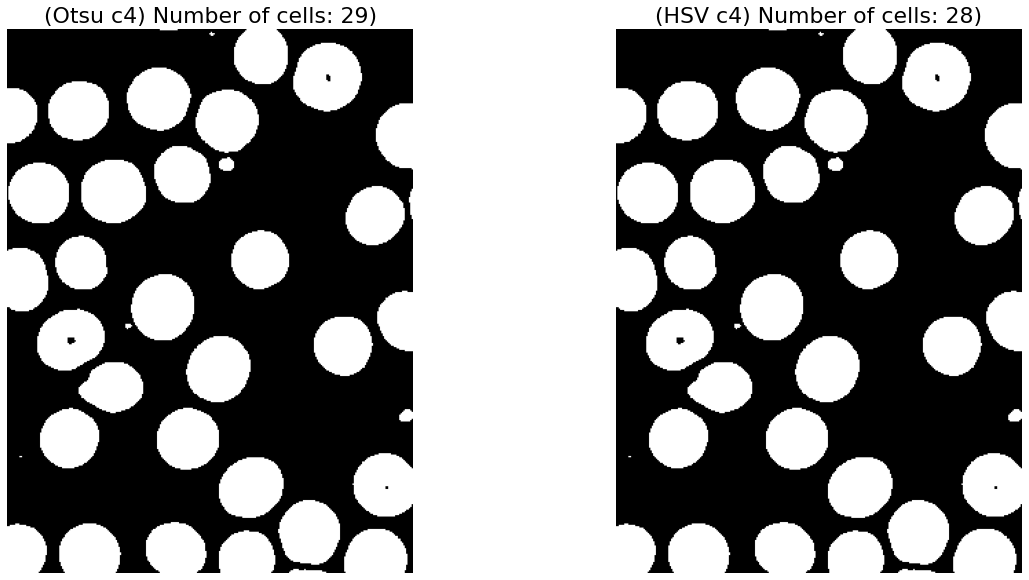

In [73]:
show_counting_num('c4.jpg',image4,cells4,image8,cells8)